# How to walk the least in Paris

In memory of Notre Dame, I plan to go to Paris. From my experience, the first question I always ask in the morning is where I should go first. I search for 10 most famous place in Paris and decide to walk between places. The objective for this worksheet is to find the shortest path to go between 10 places.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import pylab as pl
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import matplotlib.pyplot as pl
import seaborn as sns
import googlemaps
from itertools import tee
from IPython.display import HTML

In [2]:
API_key = 'AI____' #Replace your API key
gmaps = googlemaps.Client(key=API_key)

We can only put at most 10 layers in google maps. Therefore, I reduce the amount of data to visualize the problem.

In [3]:
data = pd.read_csv('Paris_attraction.csv',  encoding='utf-8')
data = data.iloc[:10,:]
data['Code']=[0,1,2,3,4,5,6,7,8,9]
locations = []
for index,row in data.iterrows():
    locations.append((row['Lat'],row['Long']))
data

,Name,Lat,Long,Code
0,Eiffel Tower,48.858372,2.294481,0
1,Louvre Museum,48.860600,2.337600,1
2,Notre-Dame de Paris,48.853000,2.349900,2
3,Arc de Triomphe,48.873800,2.295000,3
4,Wall of Love,48.884600,2.338500,4
5,The Basilica of the Sacred Heart of Paris,48.886700,2.343100,5
6,Moulin Rouge,48.884100,2.332300,6
7,Museum,48.860000,2.326600,7
8,Tuileries Garden,48.863500,2.327500,8
9,Orangerie Museum,48.863800,2.322700,9


# My estimation

In [4]:
estimate =[(9,8),(8,1),(1,2),(2,7),(7,0),(0,3),(3,6),(6,4),(4,5),(5,9)]

In [5]:
# Latitude-longitude pairs
import time 
import gmaps
import gmaps.datasets
gmaps.configure(api_key=API_key)
fig = gmaps.figure()
count = 0
color =['#ffe119','#9A6324','#800000','#808000','#e6194B','#f58231','#bfef45','#3cb44b','#42d4f4','#4363d8','#911eb4','#fabebe','#f032e6','#a9a9a9','#000075']
for i in estimate:
    path = gmaps.directions_layer(locations[i[0]], locations[i[1]],stroke_color=color[count], show_markers=True, show_route=True, 
    travel_mode='WALKING', stroke_weight=6.0, stroke_opacity=1)
    fig.add_layer(path)
    count+=1
fig

Figure(layout=FigureLayout(height='420px'))

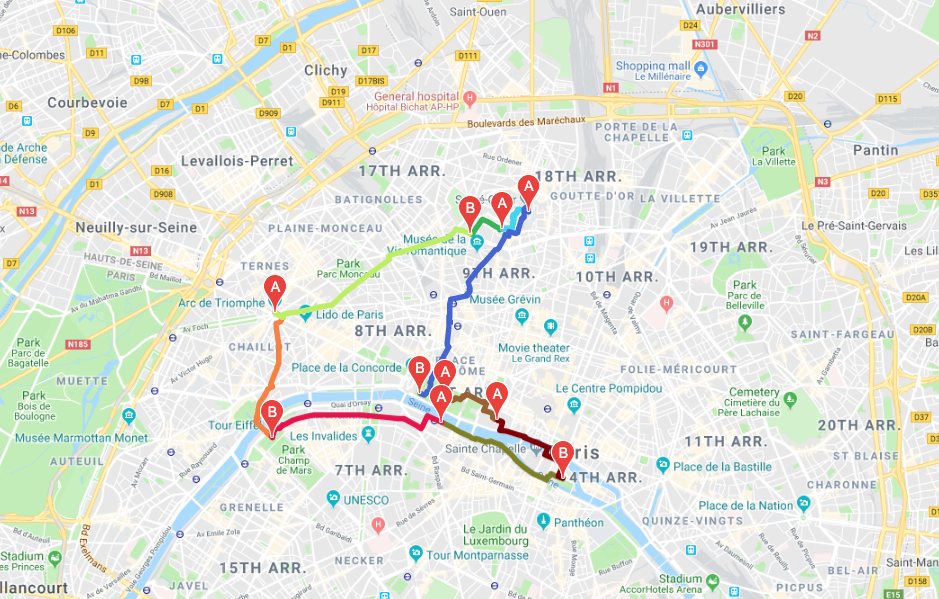

In [2]:
from IPython.display import Image
Image("before.png")

This is my estimation when I first saw 10 places. There is a river in the middle so the most natural for me to guest is walk across the river as little as possible. The following code will estimate the amount of minute I have to walk base on Google Map

In [6]:
gmaps = googlemaps.Client(key=API_key)
total = 0
for i in estimate:
    origins=locations[i[0]]
    destination = locations[i[1]]
    result = gmaps.distance_matrix(origins, destination, mode='walking')["rows"]
    dur = result[0]['elements'][0]['duration']['text']
    minute = 0
    a = [int(s) for s in dur.split() if s.isdigit()]
    minute = 0
    if len(a) == 2:
        minute = a[0]*60+a[1]
    else:
        minute=a[0]
    total+=int(minute)
print("Total: "+str(total))

Total: 236


The total amout of minutes is 236. 

# Linear Programming 

We use Linear Programming to optimize the problem.

------ Block of ugly code. ------------

-----Please ask me if you are interested-----

In [8]:
import math
import random
from gurobipy import *


# Callback - use lazy constraints to eliminate sub-tours

def subtourelim(model, where):
  if where == GRB.callback.MIPSOL:
    selected = []
    # make a list of edges selected in the solution
    for i in range(n):
      sol = model.cbGetSolution([model._vars[i,j] for j in range(n)])
      selected += [(i,j) for j in range(n) if sol[j] > 0.5]
    # find the shortest cycle in the selected edge list
    tour = subtour(selected)
    if len(tour) < n:
      # add a subtour elimination constraint
      expr = 0
      for i in range(len(tour)):
        for j in range(i+1, len(tour)):
          expr += model._vars[tour[i], tour[j]]
      model.cbLazy(expr <= len(tour)-1)


# Euclidean distance between two points

def distance(points, i, j):
    ans = 0
    origins = (points[i][0],points[i][1]) 
    destination = (points[j][0],points[j][1])
    result = gmaps.distance_matrix(origins, destination, mode='walking')["rows"]
    dur = result[0]['elements'][0]['duration']['text']
    minute = 0
    a = [int(s) for s in dur.split() if s.isdigit()]
    minute = 0
    if len(a) == 2:
        minute = a[0]*60+a[1]
    else:
        minute=a[0]
#     dur_to_int.append(minute)
    return minute

# Given a list of edges, finds the shortest subtour

def subtour(edges):
  visited = [False]*n
  cycles = []
  lengths = []
  selected = [[] for i in range(n)]
  for x,y in edges:
    selected[x].append(y)
  while True:
    current = visited.index(False)
    thiscycle = [current]
    while True:
      visited[current] = True
      neighbors = [x for x in selected[current] if not visited[x]]
      if len(neighbors) == 0:
        break
      current = neighbors[0]
      thiscycle.append(current)
    cycles.append(thiscycle)
    lengths.append(len(thiscycle))
    if sum(lengths) == n:
      break
  return cycles[lengths.index(min(lengths))]

n = 10

# Create n random points

random.seed(1)
points = []

# for i in range(n):
#   points.append((1,2))

for index,row in data.iterrows():
    points.append((row['Lat'],row['Long']))
    
m = Model()


# Create variables

vars = {}
for i in range(n):
   for j in range(i+1):
     vars[i,j] = m.addVar(obj=distance(points, i, j), vtype=GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))
     vars[j,i] = vars[i,j]
   m.update()


# Add degree-2 constraint, and forbid loops

for i in range(n):
  m.addConstr(quicksum(vars[i,j] for j in range(n)) == 2)
  vars[i,i].ub = 0

m.update()


# Optimize model

m._vars = vars
m.params.LazyConstraints = 1
m.optimize(subtourelim)

solution = m.getAttr('x', vars)
selected = [(i,j) for i in range(n) for j in range(n) if solution[i,j] > 0.5]
assert len(subtour(selected)) == n
print(solution)

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 10 rows, 55 columns and 100 nonzeros
Variable types: 0 continuous, 55 integer (55 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 0 rows and 10 columns
Presolve time: 0.00s
Presolved: 10 rows, 45 columns, 90 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 2.290000e+02, 18 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     229.0000000  229.00000  0.00%     -    0s

Cutting planes:
  Lazy constraints: 2

Explored 0 nodes (18 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 229 

Optimal solution f

The total amount of minute is 229.

Clean solution and put cleaned solution to sol array

In [9]:
total = 0
sol = {}
count = True
for i in solution:
    if solution[i]==1.0 and count==True:
        count +=1
        sol[i] = solution[i]
        count == False
    elif solution[i]==1.0:
        count=True

In [10]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key=API_key)

In [11]:
fig = gmaps.figure()
locations = []
for index,row in data.iterrows():
    locations.append((row['Lat'],row['Long']))

In [12]:
# Latitude-longitude pairs
import time 
fig = gmaps.figure()
count = 0
color =['#ffe119','#9A6324','#800000','#808000','#e6194B','#f58231','#bfef45','#3cb44b','#42d4f4','#4363d8','#911eb4','#fabebe','#f032e6','#a9a9a9','#000075']
for i in sol:
    if sol[i]==1.0 and count<10:
        path = gmaps.directions_layer(locations[i[0]], locations[i[1]],stroke_color=color[count], show_markers=False, show_route=True, 
        travel_mode='WALKING', stroke_weight=6.0, stroke_opacity=1)
        fig.add_layer(path)
        count+=1
fig

Figure(layout=FigureLayout(height='420px'))

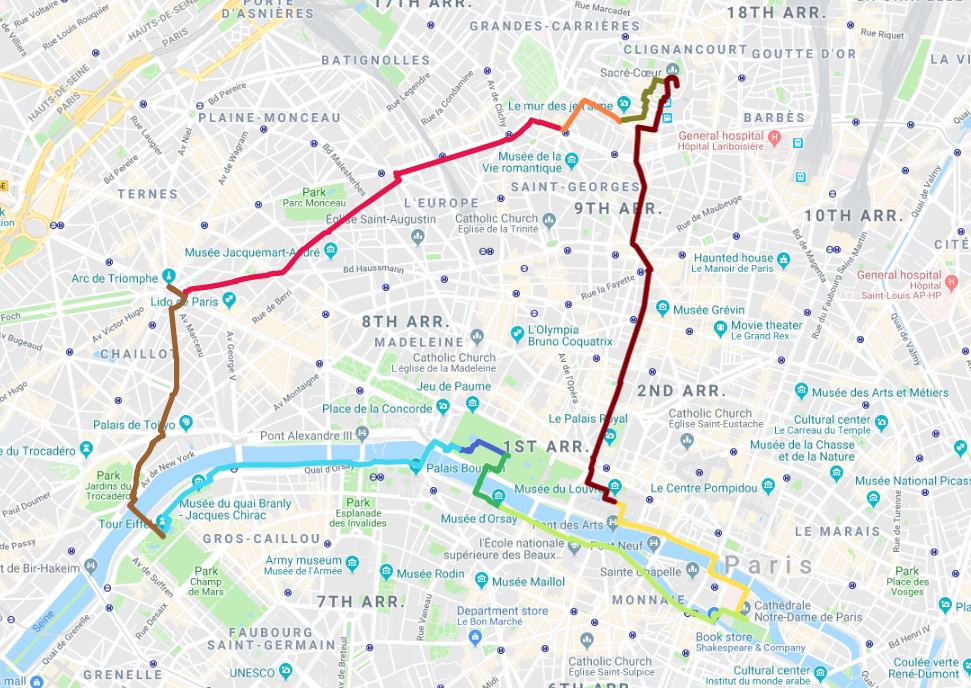

In [3]:
Image("after.png")

In [14]:
gmaps = googlemaps.Client(key=API_key)
total = 0
for i in estimate:
    origins=locations[i[0]]
    destination = locations[i[1]]
    result = gmaps.distance_matrix(origins, destination, mode='walking')["rows"]
    dur = result[0]['elements'][0]['duration']['text']
    minute = 0
    a = [int(s) for s in dur.split() if s.isdigit()]
    minute = 0
    if len(a) == 2:
        minute = a[0]*60+a[1]
    else:
        minute=a[0]
    total+=int(minute)
print("Total: "+str(total))

Total: 236


Using our estimation, the result is 236 minute. By doing optimization, we reduce the amount of walking by 7 minutes